# One vs All (One vs Rest)

## Algoritmo

En la clasificación one vs all o one vs rest, para el conjunto de datos de N instancias de clase, se tienen que generar los modelos de N clasificadores binarios. El número de etiquetas de clase presentes en el conjunto de datos y el número de clasificadores binarios generados debe ser el mismo.

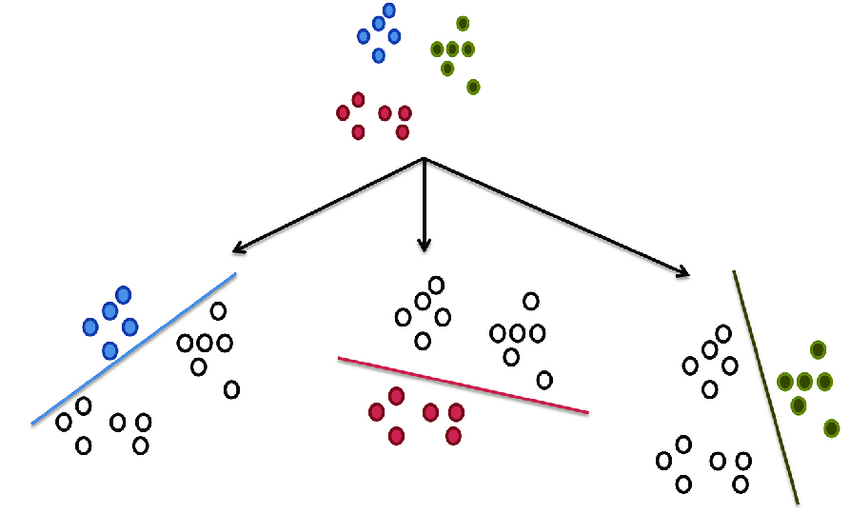

Como se muestra en la imagen anterior, considerando que se tienen tres clases, se tienen que crear igual cantidad de clasificadores: uno para cada una de las clases respectivas contra las demás.

| Clasificador | One   | All         |
| :---:        | :---  | :---        |
| 1            | Verde | Rojo, Azul  |
| 2            | Azul  | Verde, Rojo |
| 3            | Rojo  | Azul, Verde |

Para entrenar estos tres clasificadores, se tienen que crear tres conjuntos de datos de entrenamiento, uno para cada uno. 

La manera de crear estos sets de entrenamiento es mapeando, por ejemplo, de la siguiente manera:

- 1: si es del valor deseado (Verde, por ejemplo)
- 0: si no es del valor deseado (Rojo o Azul, por ejemplo)

Con este mapeo, es posible generar los 3 clasificadores binarios.

Seguidamente, con el modelo entrenado, se puede proceder a realizar predicciones. Para cada una de los valores de entrada de los cuales se desee obtener una predicción, se tienen que utilizar los 3 clasificadores. Al ser un clasificador binario, este da una probabilidad de que la entrada sea una clase o no. Al realizar esto 3 veces, se obtienen 3 probabilidades. Con estas probabilidades definidas, se selecciona como predicción la que tenga el valor más alto.

## Ventajas y desventajas

### Ventajas 

- Algoritmo sencillo conceptualmente 
- Genera buenos resultados 
- El concepto puede ser migrado a una red neuronal para mejorar la eficiencia
- Preprocesamiento de datos ligeramente más sencillo que one vs one
- En general, requiere menos modelos que one vs one

### Desventajas 

- No es eficiente cuando se utiliza con una gran cantidad de clases

## Recomendaciones de uso 

Se recomiendo utilizar este algoritmo cuando se trabaja con un dataset con un número no tan grande de clases.

# Implementación en Python para el dataset "iris"

Se importan las librerías necesarias y se configura un logger, el cual fue utilizado para debuggear, cuando fue necesario. Por el momento, ya que no es necesario, por el momento, se encuentra desactivado.

In [37]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
logging.disable()

Se carga el dataset de iris.

In [38]:
iris: Bunch = load_iris()  # type: ignore

Se obtienen los datos de entrada y de salida con los cuales se desean generar los modelos.

In [39]:
x_data: np.ndarray = iris.get("data")  # type: ignore
y_data: np.ndarray = iris.get("target")  # type: ignore

Se obtiene las clases del dataset y se genera un diccionario que relaciona su valor numérico con su nombre.

In [40]:
target_names: list[str] = iris.get("target_names")  # type:ignore
targets: dict[int, str] = {k: v for k, v in enumerate(target_names)}

Se utiliza la función de scikit learn para la selección de valores en x y y para entrenamiento y testeo.

In [41]:
train_test_arrays: list[np.ndarray] = train_test_split(
    x_data, y_data
)  # type:ignore
x_train, x_test, y_train, y_test = train_test_arrays

Se crea una función lambda que será aplicada sobre la matriz de salida para convertirla en una matriz compatible con un modelo binario. Este filtro es el importante para poder operar con el algoritmo one vs all.

In [42]:
one_vs_all_filter = lambda data, value: 1 if data == value else 0

Se genera un diccionario de modelos entrenados. Este contiene el modelo binario para cada una de las clases, utilizando el filtro mencionado con anterioridad. Esto quiere decir que este diccionario contiene solamento modelos binarios para el algoritmo de one vs all.

In [43]:
models: dict[str, LogisticRegression] = {}
                                                                                        
for target_value, target_name in targets.items():
    logging.info(f"Training model for {target_name}")
                                                                                        
    helper_array = np.ones((len(y_data), 1)).flatten() * target_value
    y_train_mapped = np.array(list(map(one_vs_all_filter, y_train, helper_array)))
                                                                                        
    model = LogisticRegression(C=10**10)
    model.fit(x_train, y_train_mapped)
                                                                                        
    models[target_name] = model

Finalmente, se itera sobre el diccionario de modelos para cada uno de los valores de entrada y salida con los que se desea probar el one vs all. Para cada valor de x, se genera un diccionario para guardar la probabilidad de que sea de alguna de las clases. Seguidamente, se obtiene la mayor probabilidad presente en el diccionario, valor que se utiliza como predicción final del algoritmo.

De igual manera, se crea una lista de booleanos para saber qué porcentaje de las predicciones finales es correcta.

In [44]:
success: list[bool] = []
for x, y in zip(x_test, y_test):
    probabilites: dict[str, float] = {}
                                                                                        
    for model_name, model in models.items():
        probability = model.predict_proba(x.reshape(1, -1))
        probabilites[model_name] = probability[0, 1]
                                                                                        
        logging.info(
            f"Probability that input {x} is of class {model_name}: {probability[0, 0]}"
        )
                                                                                        
    predicted_class = max(probabilites, key=lambda x: probabilites[x])
    logging.info(f"Max probabilty is for class {predicted_class}")
                                                                                        
    if predicted_class == targets[y]:
        success.append(True)
    else:
        success.append(False)

Porcentaje de predicciones correctar para el algoritmo one vs all.

In [45]:
print(f"Success rate: {success.count(True) / len(success)}")

Success rate: 0.9210526315789473
